<a href="https://colab.research.google.com/github/pdenailly/Probabilistic_forecasting/blob/main/Pr%C3%A9dictions_V%C3%A9los.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atelier prédictions probabilistes de séries multivariées avec la librairie GluonTS**

Bienvenu dans cet atelier ! Nous allons y explorer quelques modèles de réseaux de neurone récurrents pour la prédiction probabiliste de séries temporelles multivariées et potentiellement corrélées. 

Pour ce cas pratique nous nous intéresserons à des séries temporelles de traffic de vélo, comptés à chaque heure entre janvier et juin 2022 en plusieurs points de la ville de Paris.

Dans ce travail nous travaillerons avec la librairie *GluonTS* qui encapsule des modèles de prédiction probabiliste construits avec les librairies *MXNET* ou *Pytorch*. 



# Installation des librairies

In [ ]:
! pip install gluonts['mxnet']
! pip install matplotlib
! pip install orjson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 5.4 MB/s eta 0:00:00


# Importation des librairies nécessaires


Nous allons commencer par importer toutes les librairies nécessaires à cet atelier. Assurez vous que le fichier python *rolling_dataset* est bien présent dans votre répertoire courant. Il s'agit d'un ensemble de fonctions qui nous seront utiles pour créer une fenêtre gliassante sur la base de test.

In [ ]:
#Traitement des données
import numpy as np
import pandas as pd
import orjson

#Visualisation
import matplotlib.pyplot as plt


#Distributions et modèles disponibles
from gluonts.mx.trainer import Trainer

#Pour l'importation des données
from gluonts.dataset.repository.datasets import get_dataset
from rolling_dataset import (  #Cette fonction a disparu dans la derniÃ¨re version de GluonTS
    StepStrategy,
    generate_rolling_dataset,
)
from gluonts.dataset.common import ListDataset


#Les modèles DeepVAR
from gluonts.mx.model.deepvar import DeepVAREstimator
from gluonts.mx.distribution.lowrank_multivariate_gaussian import LowrankMultivariateGaussianOutput
from gluonts.mx.distribution.multivariate_gaussian import MultivariateGaussianOutput

#Les modèles GPVAR
from gluonts.mx.model.gpvar import GPVAREstimator
from gluonts.mx.distribution.lowrank_gp import LowrankGPOutput

#Fonctions de prédiction et d'évaluation
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator, Evaluator

# Importation des données de comptages vélos

Les données de comptages vélos sont disponibles en open source à l'adresse suivant : https://opendata.paris.fr/explore/dataset/comptage-velo-historique-donnees-compteurs. Il s'agit de données issues de comptages en différents emplacements de la ville de Paris à chaque heure. 

De cette base de données nous avons conservé 80 lieux de comptages de la ville de Paris (sans valeurs manquantes) : elles se trouvent dans le fichier 'bike_data.csv'. Assurez-vous que le fichier ait bien été importé dans le répertoire courant. Si vous rangez le fichier dans un autre répertoire, assurez vous de spécifier le chemin correct dans la fonction *read_csv* de pandas. 

Nous prendrons comme base d'entraînement la période de janvier à fin mai 2022 (soit une matrice 3575x80). 30 fenêtres glissantes seront utilisées en test pour couvrir l'ensemble du mois de juin 2022 (avec 24 tranches horaires de prédites à chaque fenêtre).

In [ ]:
#Importation des données de comptage vélos depuis le fichier .csv
bike_data = pd.read_csv('bike_data.csv', sep=",", index_col=1, parse_dates=True, decimal='.').iloc[: , 1:]  

#Base d'entrainement
bike_data_train = bike_data[:pd.Timestamp('2022-05-31 23:00:00', freq='H')]
bike_data_train = bike_data_train.transpose()

#La base de test contient les comptages d'un mois supplémentaire - non utilisé dans l'apprentissage
bike_data_test = bike_data
bike_data_test = bike_data_test.transpose()

<ipython-input-3-bca0bd57a080>:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  bike_data_train = bike_data[:pd.Timestamp('2022-05-31 23:00:00', freq='H')]


Maintenant il s'agit de mettre ces données sous un format compréhensible par la librairie GluonTS que nous utiliserons dans cet atelier. Vous n'avez pas besoin de comprendre dans le détail ce code, juste que GluonTS a besoin de données comprenant des balises particulières 'target', 'start', etc.. Ce format permet aux différentes fonctions d'entraînement et d'évaluation d'aller chercher les bonnes informations dans les données. 

Nous transformons également la base de test en un objet itérable. Le but est de pouvoir faire des prédictions sur plusieurs fenêtres afin de pouvoir couvrir tout le mois de Juin. Nous ilustrerons ces fenêtres ultérieurement.

In [ ]:
#Données mises sous la forme d'objets ListDataset, compréhensibles par GluonTS 
train_ds = ListDataset([{"start": pd.Timestamp('2022-01-03 00:00:00', freq='H'), "target": bike_data_train}], freq='H', one_dim_target=False)
test_ds = ListDataset([{"start": pd.Timestamp('2022-01-03 00:00:00', freq='H'), "target": bike_data_test}], freq='H', one_dim_target=False)

#Mise en place d'une stratégie permettant de subdiviser la base de test en plusieurs fenêtres à prédire (tailles 24)        
strategy=StepStrategy(
      prediction_length=24,
      step_size=24
 )
 
#Cette liste intègrera l'ensemble des fenêtres de test à prédire
ds = []

#Récupération de la base de test, à convertir en df
item = (next(iter(test_ds)))
target = item["target"]
start = item["start"]
index = pd.date_range(start=str(start), periods=target.shape[1], freq='H')
series = pd.DataFrame(target.T, index=index)

prediction_window = series
nb_j = 0
         
for window in strategy.get_windows(prediction_window):
    nb_j = nb_j + 1
    new_item = item.copy()
    new_item['target'] = np.concatenate(
        [window.to_numpy()]
      ).T
    ds.append(new_item)
    if nb_j > 29:
      break
  
test_ds = ds
target_dim=int(test_ds[1]['target'].shape[0])
freq='H'
prediction_length = 24

<ipython-input-4-6d4733ef5b19>:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  train_ds = ListDataset([{"start": pd.Timestamp('2022-01-03 00:00:00', freq='H'), "target": bike_data_train}], freq='H', one_dim_target=False)
<ipython-input-4-6d4733ef5b19>:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  test_ds = ListDataset([{"start": pd.Timestamp('2022-01-03 00:00:00', freq='H'), "target": bike_data_test}], freq='H', one_dim_target=False)


Maintenant que nos données d'entrainement (train_ds) et de d'évaluation (test_ds) ont été crées, nous pouvons les visualiser un peu. Pour commencer voyons quelques informations à leur propos.

In [ ]:
print(f"Longueur d'une fenêtre de prédiction dans la base de test': {prediction_length}")
print(f"Fréquence des séries temporelles: {freq}")
print(f"Nombre de séries temporelles: {target_dim}")
print(f"Nombre de fenêtres glissantes dans la base de test: {len(test_ds)}")
print(f"Nombre d'heures dans la base d'entrainement: {(train_ds[0]['target'].shape[1])}")
print(f"Nombre total d'heures dans la base de test: {(test_ds[0]['target'].shape[1]) - (train_ds[0]['target'].shape[1])}")

Longueur d'une fenêtre de prédiction dans la base de test': 24
Fréquence des séries temporelles: H
Nombre de séries temporelles: 80
Nombre de fenêtres glissantes dans la base de test: 30
Nombre d'heures dans la base d'entrainement: 3575
Nombre total d'heures dans la base de test: 720


Nous pouvons également visualiser quelques séries de comptages. Par exemple regardons les 5 premières séries sur la première semaine de la base d'entraînement. Vous pouvez modifier ici avec le nombre de séries (n_series) et le nombre de jours (n_jours).

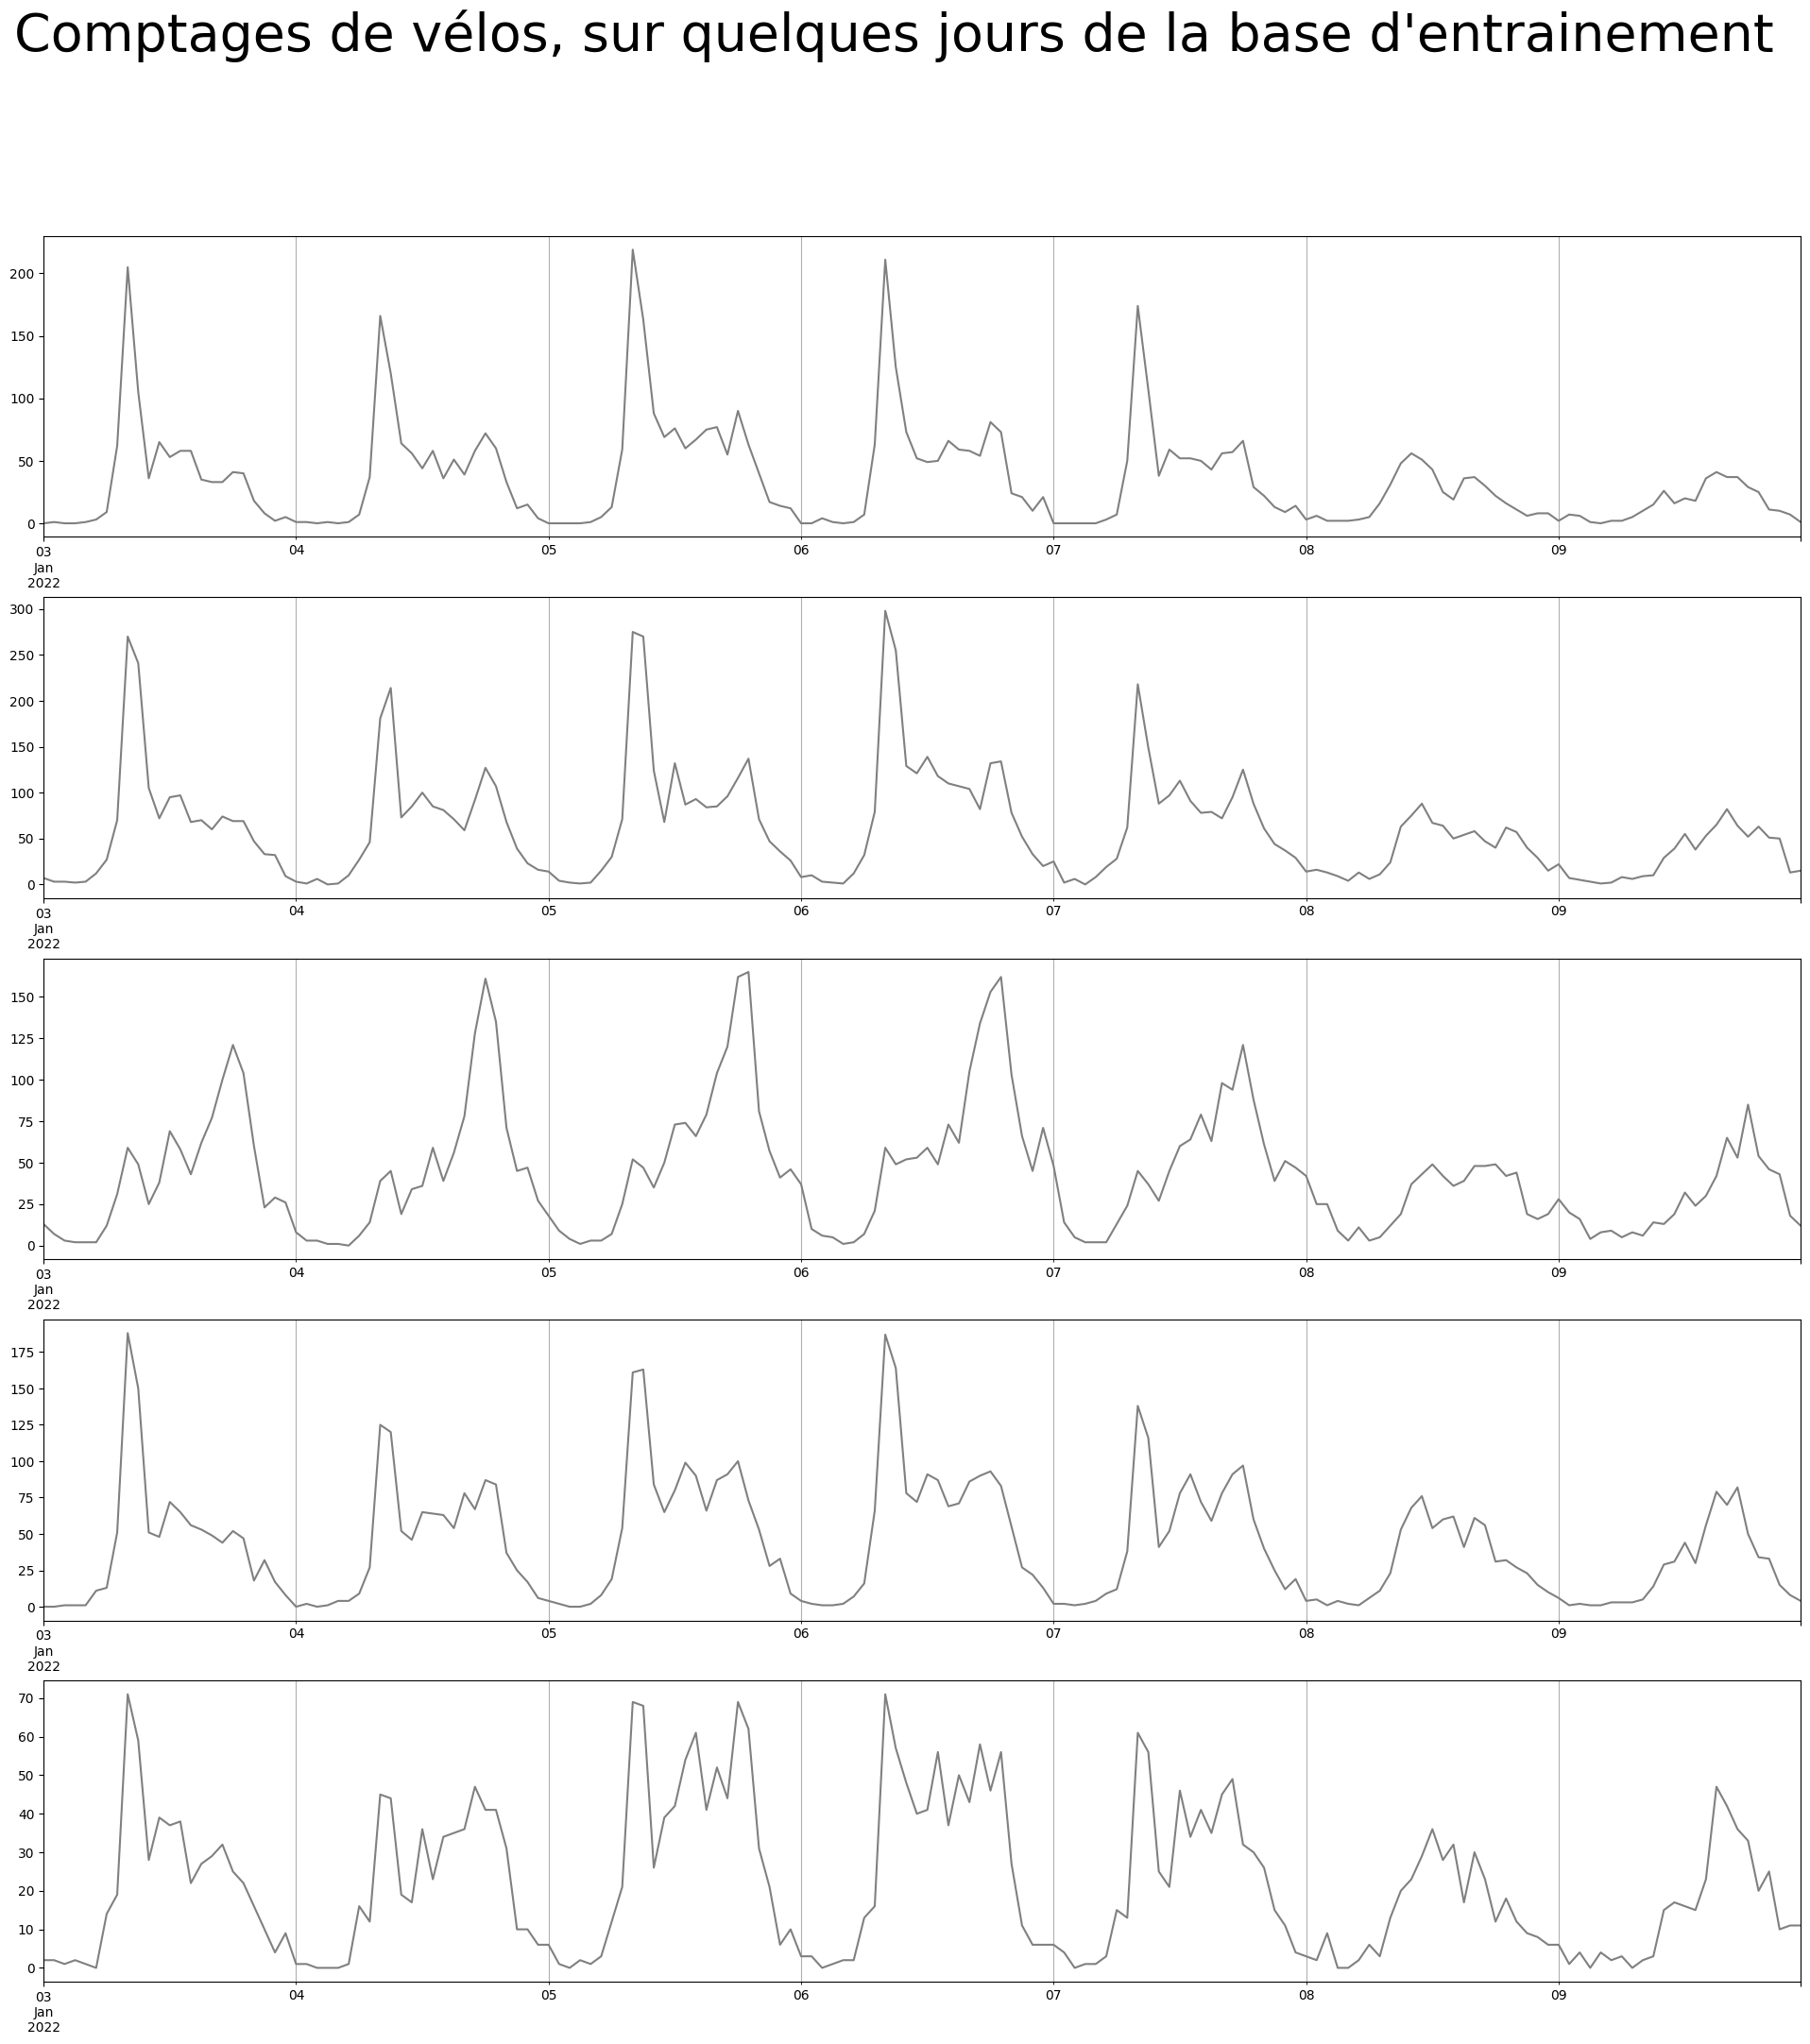

In [ ]:
##Elicitation du nombre de séries et du nombre de jours que l'on souhaite visualiser (MODIFIABLE)
n_jours = 7
n_series = 5

##On remet en forme les données sous forme de dataframes pour la visualisation

#Entrainement
target = train_ds[0]['target'].T
start = train_ds[0]['start']
periods = target.shape[0]
index = pd.date_range(start=start.strftime('%Y-%m-%d %H:%M:%S'), periods=periods, freq=start.freq)
series_train = pd.DataFrame(target, index=index)

#Test
target = test_ds[0]['target'].T
start = test_ds[0]['start']
periods = target.shape[0]
index = pd.date_range(start=start.strftime('%Y-%m-%d %H:%M:%S'), periods=periods, freq=start.freq)
series_test = pd.DataFrame(target, index=index)

##Création des subplots dans lesquels seront représentés les graphiques
label_prefix = ""
rows = n_series
cols = 1
fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
fig.suptitle('Comptages de vélos, sur quelques jours de la base d\'entrainement', fontsize=40)
axx = axs
                  
for dim in range(0, int((rows*cols))):
    ax = axx[dim]
    ax.grid(which="both")
    series_train[:(n_jours)*prediction_length][dim].plot(ax=ax, color = 'grey') 

Nous remarquons deux éléments sur ces séries :


1.   Les jours de semaine et les jours de weekend ont des profils bien différents. Les jours de semaine présentent ainsi des pics de fréquentation que l'on ne voit pas le weekend.
2.   Ces pics de fréquentation peuvent se trouver le matin pour certains capteurs, ou le soir pour d'autres. Ce phénomène doit provenir directement de la situation des capteurs dans la ville : certains proches des zones de fort passage le matin, d'autres proches des zones de fort passage le soir.

Nous pouvons également visualiser quelques fenêtres glissantes pour nous faire une idée des différentes fréquentations que l'on aura à prédire. Là encore vous pouvez modifier le nombre de séries que vous souhaitez visualiser (n_series).


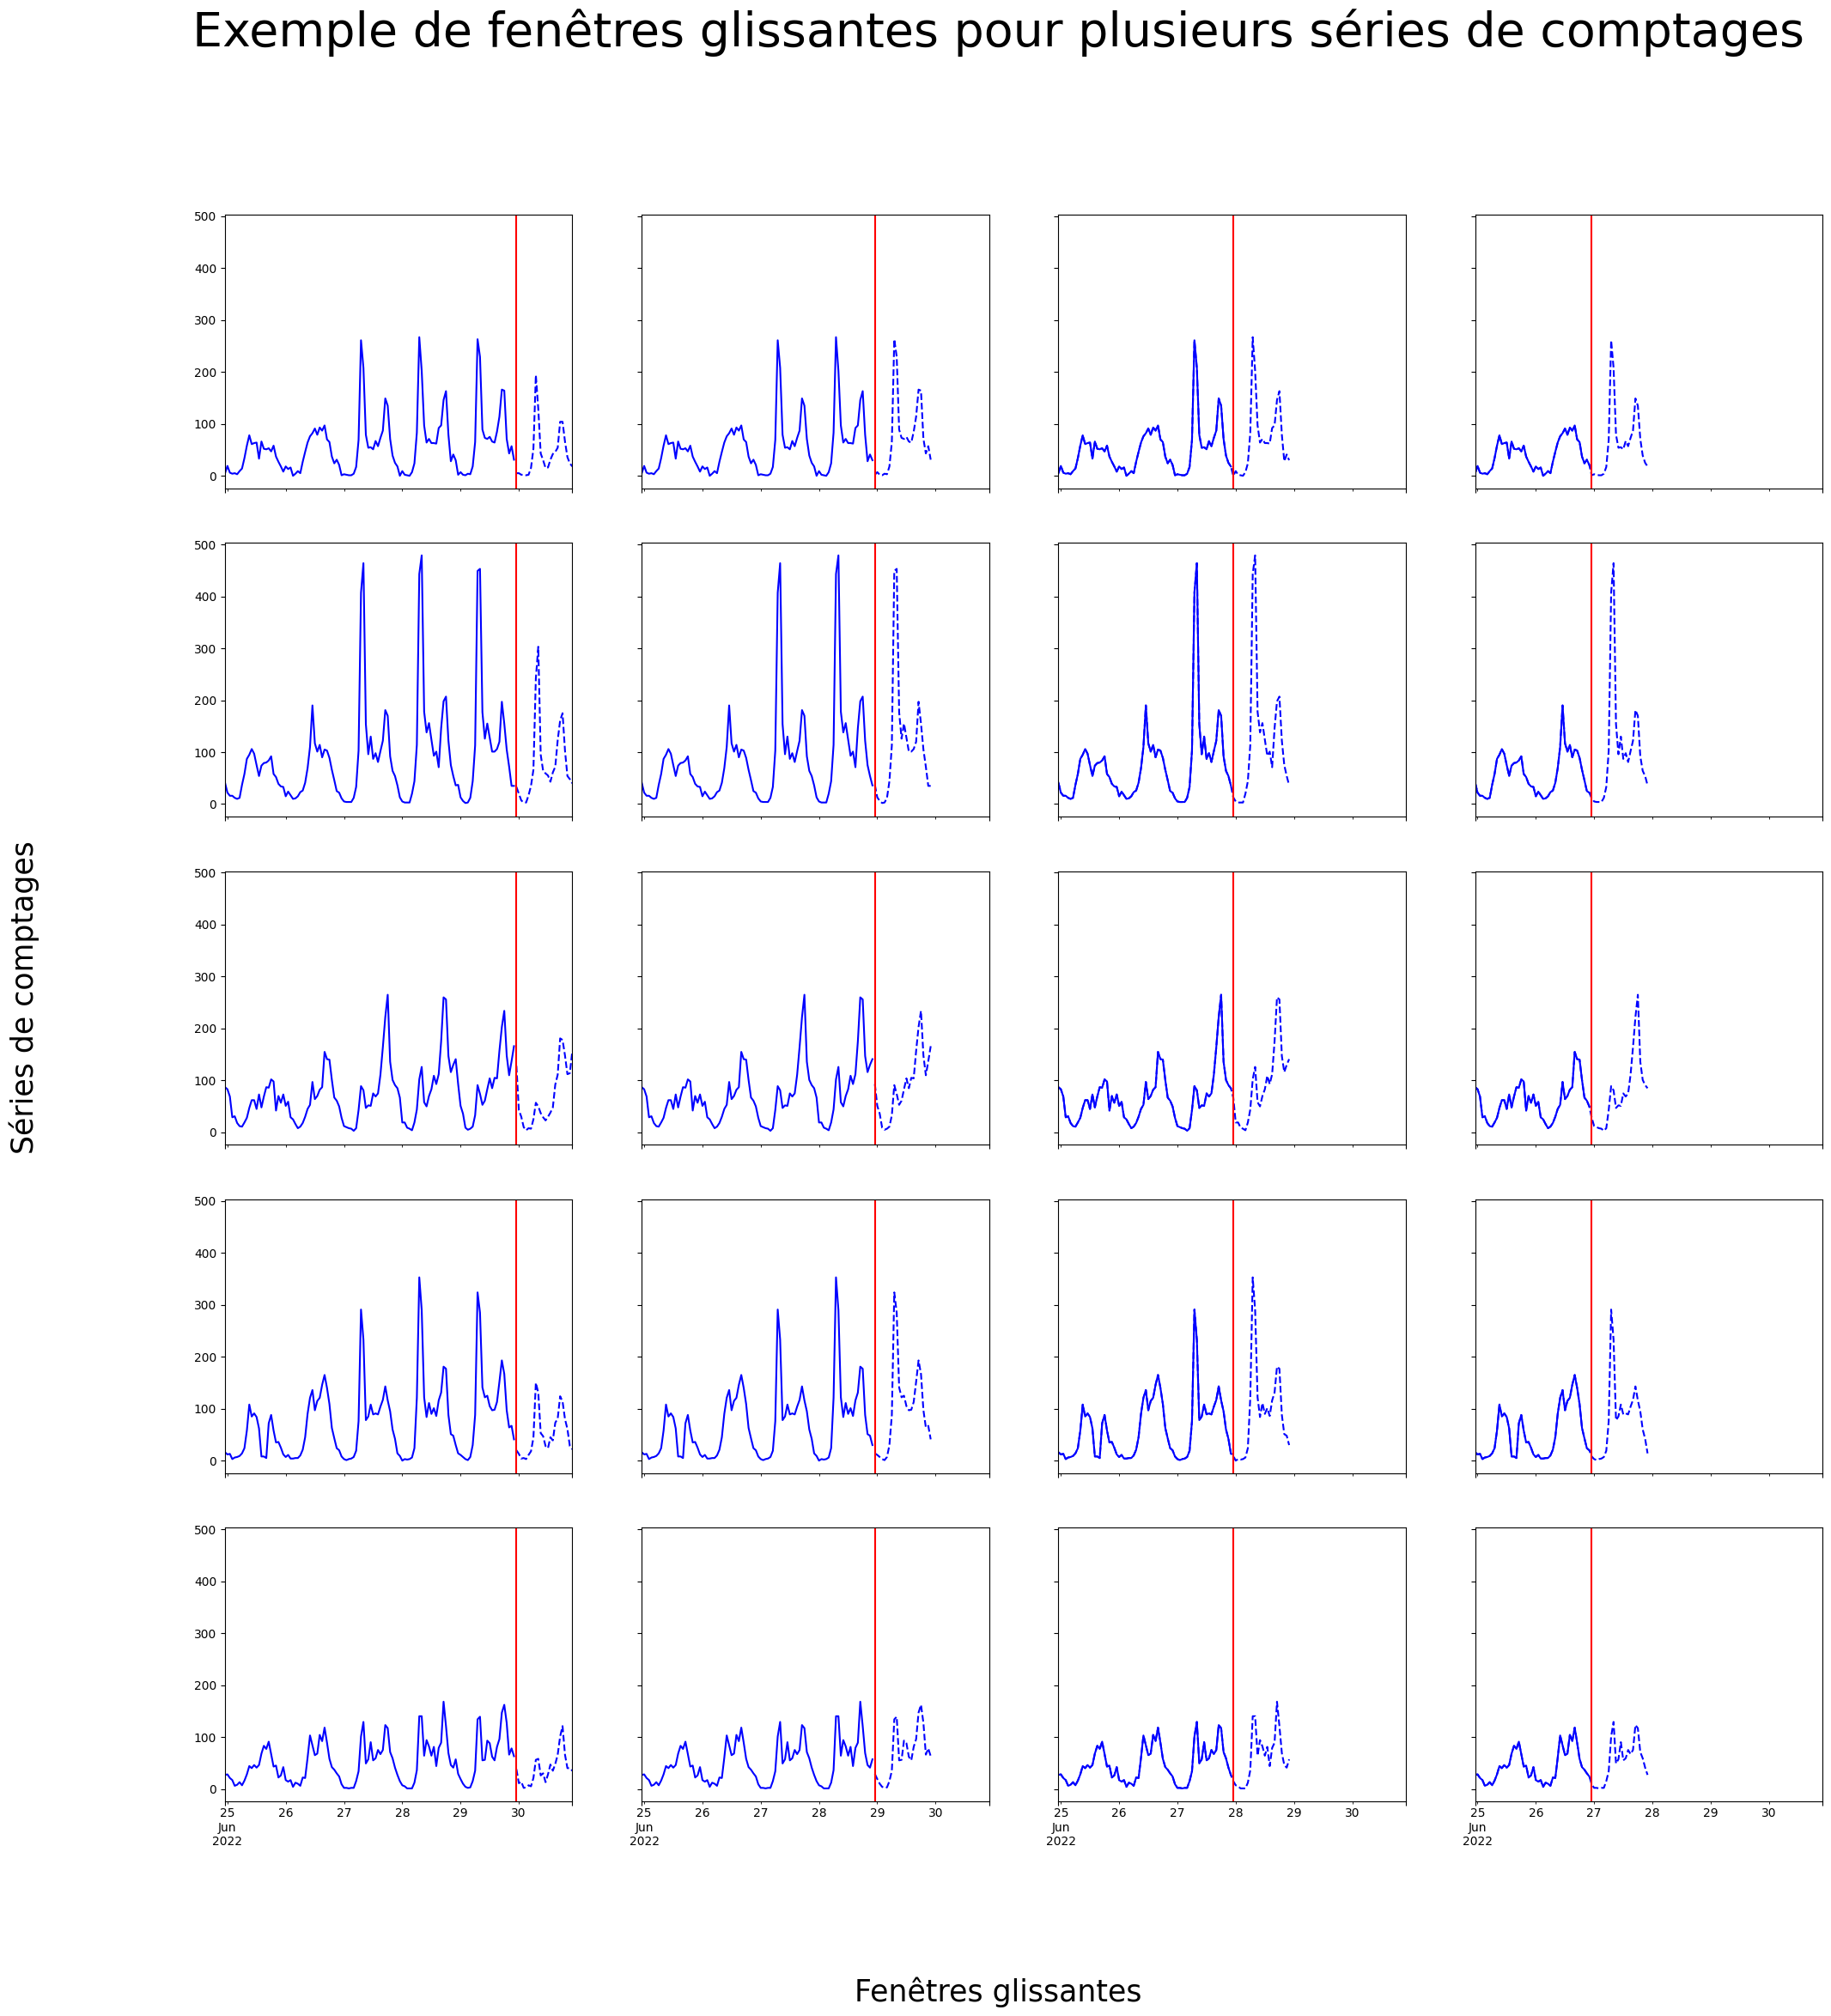

In [ ]:
#Nombre de séries que l'on visualisera
n_series = 5

label_prefix = ""
rows = n_series
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(24, 24), sharex=True, sharey=True)

fig.supxlabel('Fenêtres glissantes', fontsize=25)
fig.supylabel('Séries de comptages', fontsize=25)

fig.suptitle('Exemple de fenêtres glissantes pour plusieurs séries de comptages', fontsize=40)
axx = axs

                  
for dim in range(0, rows):
    ax3 = axx[dim, 3]
    series_test[-(6*prediction_length):-(4*prediction_length)][dim].plot(ax=ax3, color = 'blue')
    series_test[-(6*prediction_length):-(3*prediction_length)][dim].plot(ax=ax3, color = 'blue', linestyle='dashed')
    ax3.axvline(series_test.index[-(4*prediction_length)], color="r")
    
    ax2 = axx[dim, 2]
    series_test[-(6*prediction_length):-(3*prediction_length)][dim].plot(ax=ax2, color = 'blue')
    series_test[-(6*prediction_length):-(2*prediction_length)][dim].plot(ax=ax2, color = 'blue', linestyle='dashed')
    ax2.axvline(series_test.index[-(3*prediction_length)], color="r")
    
    ax1 = axx[dim, 1]
    series_test[-(6*prediction_length):-(2*prediction_length)][dim].plot(ax=ax1, color = 'blue')
    series_test[-(2*prediction_length):-prediction_length][dim].plot(ax=ax1, color = 'blue', linestyle='dashed')
    ax1.axvline(series_test.index[-(2*prediction_length)], color="r")
    
    ax0 = axx[dim, 0]
    series_test[-(6*prediction_length):-prediction_length][dim].plot(ax=ax0, color = 'blue')
    series_test[-prediction_length:][dim].plot(ax=ax0, color = 'blue', linestyle='dashed')
    ax0.axvline(series_test.index[-prediction_length], color="r")

Cette figure montre un exemple de 4 fenêtres glissantes, visualisées pour *n_series* séries de comptages. On prédit par exemple la dernière journée de juin, puis le 29 juin, puis le 28, ...

Nous allons maintenant passer à l'application de modèles de prédiction probabilistes sur ces données ! Les modèles sont ceux que nous avons vu dans la présentation (référez vous à la table récapitulative des modèles). Tous les modèles sont des réseaux de neurone récurrents avec une distribution en sortie pour de la prédiction probabiliste :
* **Vec-lstm-fullrank-scaling** : intègre une distribution gaussienne avec une matrice de covariance pleine, et où les données en entrée sont mises à l'échelle par la moyenne.
* **Vec-lstm-lowrank-copula** : intègre une distribution gaussienne de faible rang et transforme les données en entrée avec des copules gaussiennes.
* **GP-copula** : applique un LSTM sur des sous groupes de séries avant de construire la distribution jointe avec une gaussienne de faible rang. Une transformation basée sur les copules est appliquée en entrée.

# Entraînement d'un modèle de prédiction Vec-LSTM-fullrank-Scaling

Commençons avec notre premier modèle ! Pour commencer nous allons travailler avec un modèle Vec-lstm pour lequel il n'y a pas de transformation des données en entrée par Copules gaussiennes et qui n'utilise pas de matrice de faible rang. Les modèles Vec-lstm sont encodés sous la classe d'estimateurs *DeepVAR* sur *GluonTS*. 

Commençons par éliciter le modèle et ses différentes options. Nous allons choisir un entrainement sur 3 epochs avec 10 batches par epoch. Nous allons également spécifier un dropout à 0.01 et un taux d'apprentissage à 10-3. Nous utilisons des lags à 1, 2, 12 et 24 heures pour le modèle autorégressif.

In [ ]:
estimator = DeepVAREstimator(
            target_dim=target_dim,
            dropout_rate=0.01,
            prediction_length=prediction_length,
            cell_type="lstm",
            lags_seq = [1, 12, 24],
            conditioning_length = 50,
            scaling=True,
            freq=freq,
            use_marginal_transformation=False,
            distr_output=MultivariateGaussianOutput(dim = target_dim),
            trainer=Trainer(
         epochs=5,
         learning_rate=1e-3,
         num_batches_per_epoch=10),
        )

Une fois l'object "estimator" crée, nous pouvons lancer l'entraînement avec les options précisées. On va lancer sur 10 epochs, celui ci devrait aller assez vite.

In [ ]:
predictor = estimator.train(train_ds)

100%|██████████| 8/8 [00:17<00:00,  2.22s/it, epoch=5/5, avg_epoch_loss=340]


Voilà le modèle a été entraîné comme il faut. Vous constaterez que la loss (la -log vraisemblance) a diminué à chaque epoch, ce qui souligne qu'un apprentissage a bien eu lieu. 

Maintenant nous voulons regarder quelques statistiques de prédiction sur la base de prédiction. Pour cela des métriques (CRPS, MAPE, etc..) peuvent être calculées et moyennées sur l'ensemble des fenêtres de la base de prédiction. Pour lancer les prédictions, on peut utiliser la commande *make_evaluation_prediction* de Gluonts, elle peut prendre quelques dizaines de secondes à quelques minutes selon la taille des données et le nombre de répétitions (échantillons de Monte-Carlo). Pour nous cela devrait aller assez vite. Nous allons spécifier que nous répétons 30 fois chaque prédictions pour calculer des quantiles de prédictions.

In [ ]:
#Prédictions sur fenêtres glissantes
forecast_it, ts_it = make_evaluation_predictions(
                test_ds, predictor=predictor, num_samples=30
            )

forecasts = list(forecast_it)
targets = list(ts_it)

Assurons nous de la dimension des objets crées lors de la prédiction, par exemple sur la dernière fenêtre.

In [ ]:
forecast_entry = forecasts[-1]
print(f"Nombre de répétitions de prédictions: {forecast_entry.num_samples}")
print(f"Dimension des prédictions pour la fenêtre: {forecast_entry.samples.shape}")
print(f"Date de départ de la fenêtre: {forecast_entry.start_date}")
print(f"Fréquence de la série temporelle: {forecast_entry.freq}")

Nombre de répétitions de prédictions: 30
Dimension des prédictions pour la fenêtre: (30, 24, 80)
Date de départ de la fenêtre: 2022-05-31 23:00
Fréquence de la série temporelle: <Hour>


Pour la fenêtre étudiée, vous remarquerez que la dimension correspond à (*num_samples* X *prediction_length* X *target_dim*), ce qui est attendu pour nous (30 prédictions de faites, par série et par heure).

Calculons nos métriques d'évaluation maintenant.
Nous utilisons la classe *Evaluator* qui peut calculer des mesures de performance agrégées.

In [ ]:
# Evaluation
evaluator = MultivariateEvaluator()

agg_metric, item_metrics = evaluator(
                    targets, forecasts, num_series=len(test_ds)
                )

print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("MSE: {}".format(agg_metric['MSE']))

Running evaluation: 30it [00:00, 109.96it/s]
Running evaluation: 30it [00:00, 116.13it/s]
Running evaluation: 30it [00:00, 120.33it/s]
Running evaluation: 30it [00:00, 59.36it/s]
Running evaluation: 30it [00:01, 25.83it/s]
Running evaluation: 30it [00:00, 80.22it/s]
Running evaluation: 30it [00:00, 72.36it/s]
Running evaluation: 30it [00:00, 71.94it/s]
Running evaluation: 30it [00:00, 67.04it/s]
Running evaluation: 30it [00:00, 70.00it/s]
Running evaluation: 30it [00:00, 82.51it/s]
Running evaluation: 30it [00:00, 100.74it/s]
Running evaluation: 30it [00:00, 105.49it/s]
Running evaluation: 30it [00:00, 109.91it/s]
Running evaluation: 30it [00:00, 109.55it/s]
Running evaluation: 30it [00:00, 122.12it/s]
/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.9/dist-packages/gluonts/evaluation/_base.py:513: RuntimeWarning: divide by zero encountered in d

CRPS: 0.7004307386061503
MSE: 15302.423468981435


Notez bien les résultats des métriques CRPS et MSE que vous obtenez.
Un certain nombre de paramètres, appelés hyperparamètres, sont inconnus a priori et il faut estimer plusieurs modèles avec différentes valeurs de ces hyperparamètres. On passe généralement par une grille de recherche (grid search) mais nous n'allons pas le faire ici. 

Plusieurs hyperparamètres peuvent être étudiés : le nombre de cellules de LSTM, le nombre de couches, le taux d'apprentissage, le nombre d'itérations d'apprentissage, etc.. Nous allons tester la modification d'un hyperparamètre et constater son effet sur les capacités de prédiction du modèle.

A vous de jouer maintenant !
Lancez l'apprentissage du même modèle DeepVAR précédent mais en considérant cette fois 3 couches pour le réseau de neurone récurrent (cherchez dans la documentation *gluonts.mx.model.deepvar* l'option dédiée et modifiez l'objet *estimator*, vous relancez ensuite l'apprentissage et l'évaluation sur la base de test). Que constatez vous ? Y a t-il une amélioration ou non des métriques calculées (CRPS, MSE) ? 

Une fois cette petite expérience effectuée nous allons étudier un autre modèle, potentiellement plus robuste.

# Entraînement d'un modèle de prédiction Vec-LSTM-lowrank-Copula

Nous allons maintenant passer à un autre modèle : le *Vec-lstm-lowrank-Copula*. Vous allez construire l'estimateur pour ce modèle. Voici quelques indications :
* Il s'agit d'un modèle Vec-lstm : utilisez la même classe *DeepVAREstimator* que pour le 1er modèle
* Utilisez les options *scaling* et *use_marginal_transformation* pour gérer la transformation de vos données en entrée. Il s'agit de deux options de transformation, n'utilisez pas les deux ! (documentation dans https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.model.deepvar.html)
* Utilisez une distribution de sortie adaptée. Dans le premier modèle nous avions une distribution gaussienne avec matrice de covariance pleine (*MultivariateGaussianOutput*), ici nous souhaitons une distribution gaussienne avec matrice de faible rang en sortie. Cherchez la distribution adaptée dans la documentation : https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.distribution.html (utilisez la liste des modules en bas de page). Choisissez un rang pour la matrice de covariance (une valeur petite, 5 par exemple, attention vous devez également préciser cette valeur de rang comme argument de *DeepVAREstimator*).
* Enfin nous conserverons les mêmes valeurs d'hyperparamètres que dans le 1er modèle pour le réseau de neurone (nombre d'epochs, lags, dropout, etc.).

In [ ]:
#Construction de l'estimateur pour un modèle Vec-lstm-lowrank-copula

estimator = DeepVAREstimator(
            target_dim=target_dim,
            dropout_rate=0.01,
            prediction_length=prediction_length,
            cell_type="lstm",
            lags_seq = [1, 2, 12, 24],
            scaling=False,
            freq=freq,
            use_marginal_transformation=True,
            rank = 5,
            distr_output=LowrankMultivariateGaussianOutput(rank = 5, dim = target_dim),
            trainer=Trainer(
         epochs=10,
         learning_rate=1e-3,
         num_batches_per_epoch=10),
        )


#Entrainement sur la base d'apprentissage avec l'estimateur crée
predictor = estimator.train(train_ds)


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/gluonts/transform/convert.py:556: RuntimeWarning: divide by zero encountered in true_divide
  x_diff == 0.0, np.zeros_like(x_diff), y_diff / x_diff
100%|██████████| 10/10 [00:06<00:00,  1.62it/s, epoch=10/10, avg_epoch_loss=7.95]


Si vous avez bien construit le modèle, vous devriez vous rendre compte que l'apprentissage est plus rapide. 

Le modèle a effectivement beaucoup moins de paramètres à apprendre dans le cas d'une matrice de covariance de faible rang par rapport à une matrice pleine. Vous devriez également constater qu'au bout de 5 epochs, la loss continue de décroitre beaucoup.

Ce modèle est plus rapide mais est-il meilleur que le premier ? Lancez une prédiction sur les fenêtres de la base de test et calculez les métriques CRPS et MSE. Y a t-il eu une amélioration par rapport au modèle Vec-lstm-fullrank-scaling ? A votre avis pourquoi ?

In [ ]:
#Prédictions sur fenêtres glissantes
forecast_it, ts_it = make_evaluation_predictions(
                test_ds, predictor=predictor, num_samples=30
            )

forecasts = list(forecast_it)
targets = list(ts_it)

# Evaluation
agg_metric, item_metrics = evaluator(
                    targets, forecasts, num_series=len(test_ds)
                )

print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("MSE: {}".format(agg_metric['MSE']))


/usr/local/lib/python3.9/dist-packages/gluonts/transform/convert.py:809: RuntimeWarning: divide by zero encountered in true_divide
  (
/usr/local/lib/python3.9/dist-packages/gluonts/transform/convert.py:809: RuntimeWarning: invalid value encountered in true_divide
  (
Running evaluation: 30it [00:00, 97.17it/s]
Running evaluation: 30it [00:00, 106.90it/s]
Running evaluation: 30it [00:00, 109.24it/s]
Running evaluation: 30it [00:00, 105.33it/s]
Running evaluation: 30it [00:00, 115.62it/s]
Running evaluation: 30it [00:00, 106.96it/s]
Running evaluation: 30it [00:00, 83.42it/s]
Running evaluation: 30it [00:00, 46.99it/s]
Running evaluation: 30it [00:00, 42.87it/s]
Running evaluation: 30it [00:00, 74.97it/s]
Running evaluation: 30it [00:00, 69.08it/s]
Running evaluation: 30it [00:00, 68.37it/s]
Running evaluation: 30it [00:00, 67.44it/s]
Running evaluation: 30it [00:00, 87.03it/s]
Running evaluation: 30it [00:00, 109.31it/s]
Running evaluation: 30it [00:00, 100.14it/s]
/usr/local/lib/pytho

CRPS: 0.47418925637041653
MSE: 7854.094946087797


Essayez de nouveau de lancer un entraînement avec ce modèle mais pour 10 epochs. Constatez vous une amélioration des métriques ?

Maintenant nous pouvons visualiser les résultats de prédictions sur quelques fenêtres. La fonction ci-dessous permet de visualiser les profils observés et des enveloppes de prédiction que l'on peut préciser. Ces enveloppes de prédiction sont calculées à partir des quantiles des échantillons de séries prédites.

In [ ]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 3
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-3 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
        
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )


Testons cette fonction sur les prédictions faites avec le modèle Vec-lstm-lowrank-Copula. Nous représentons 12 séries.

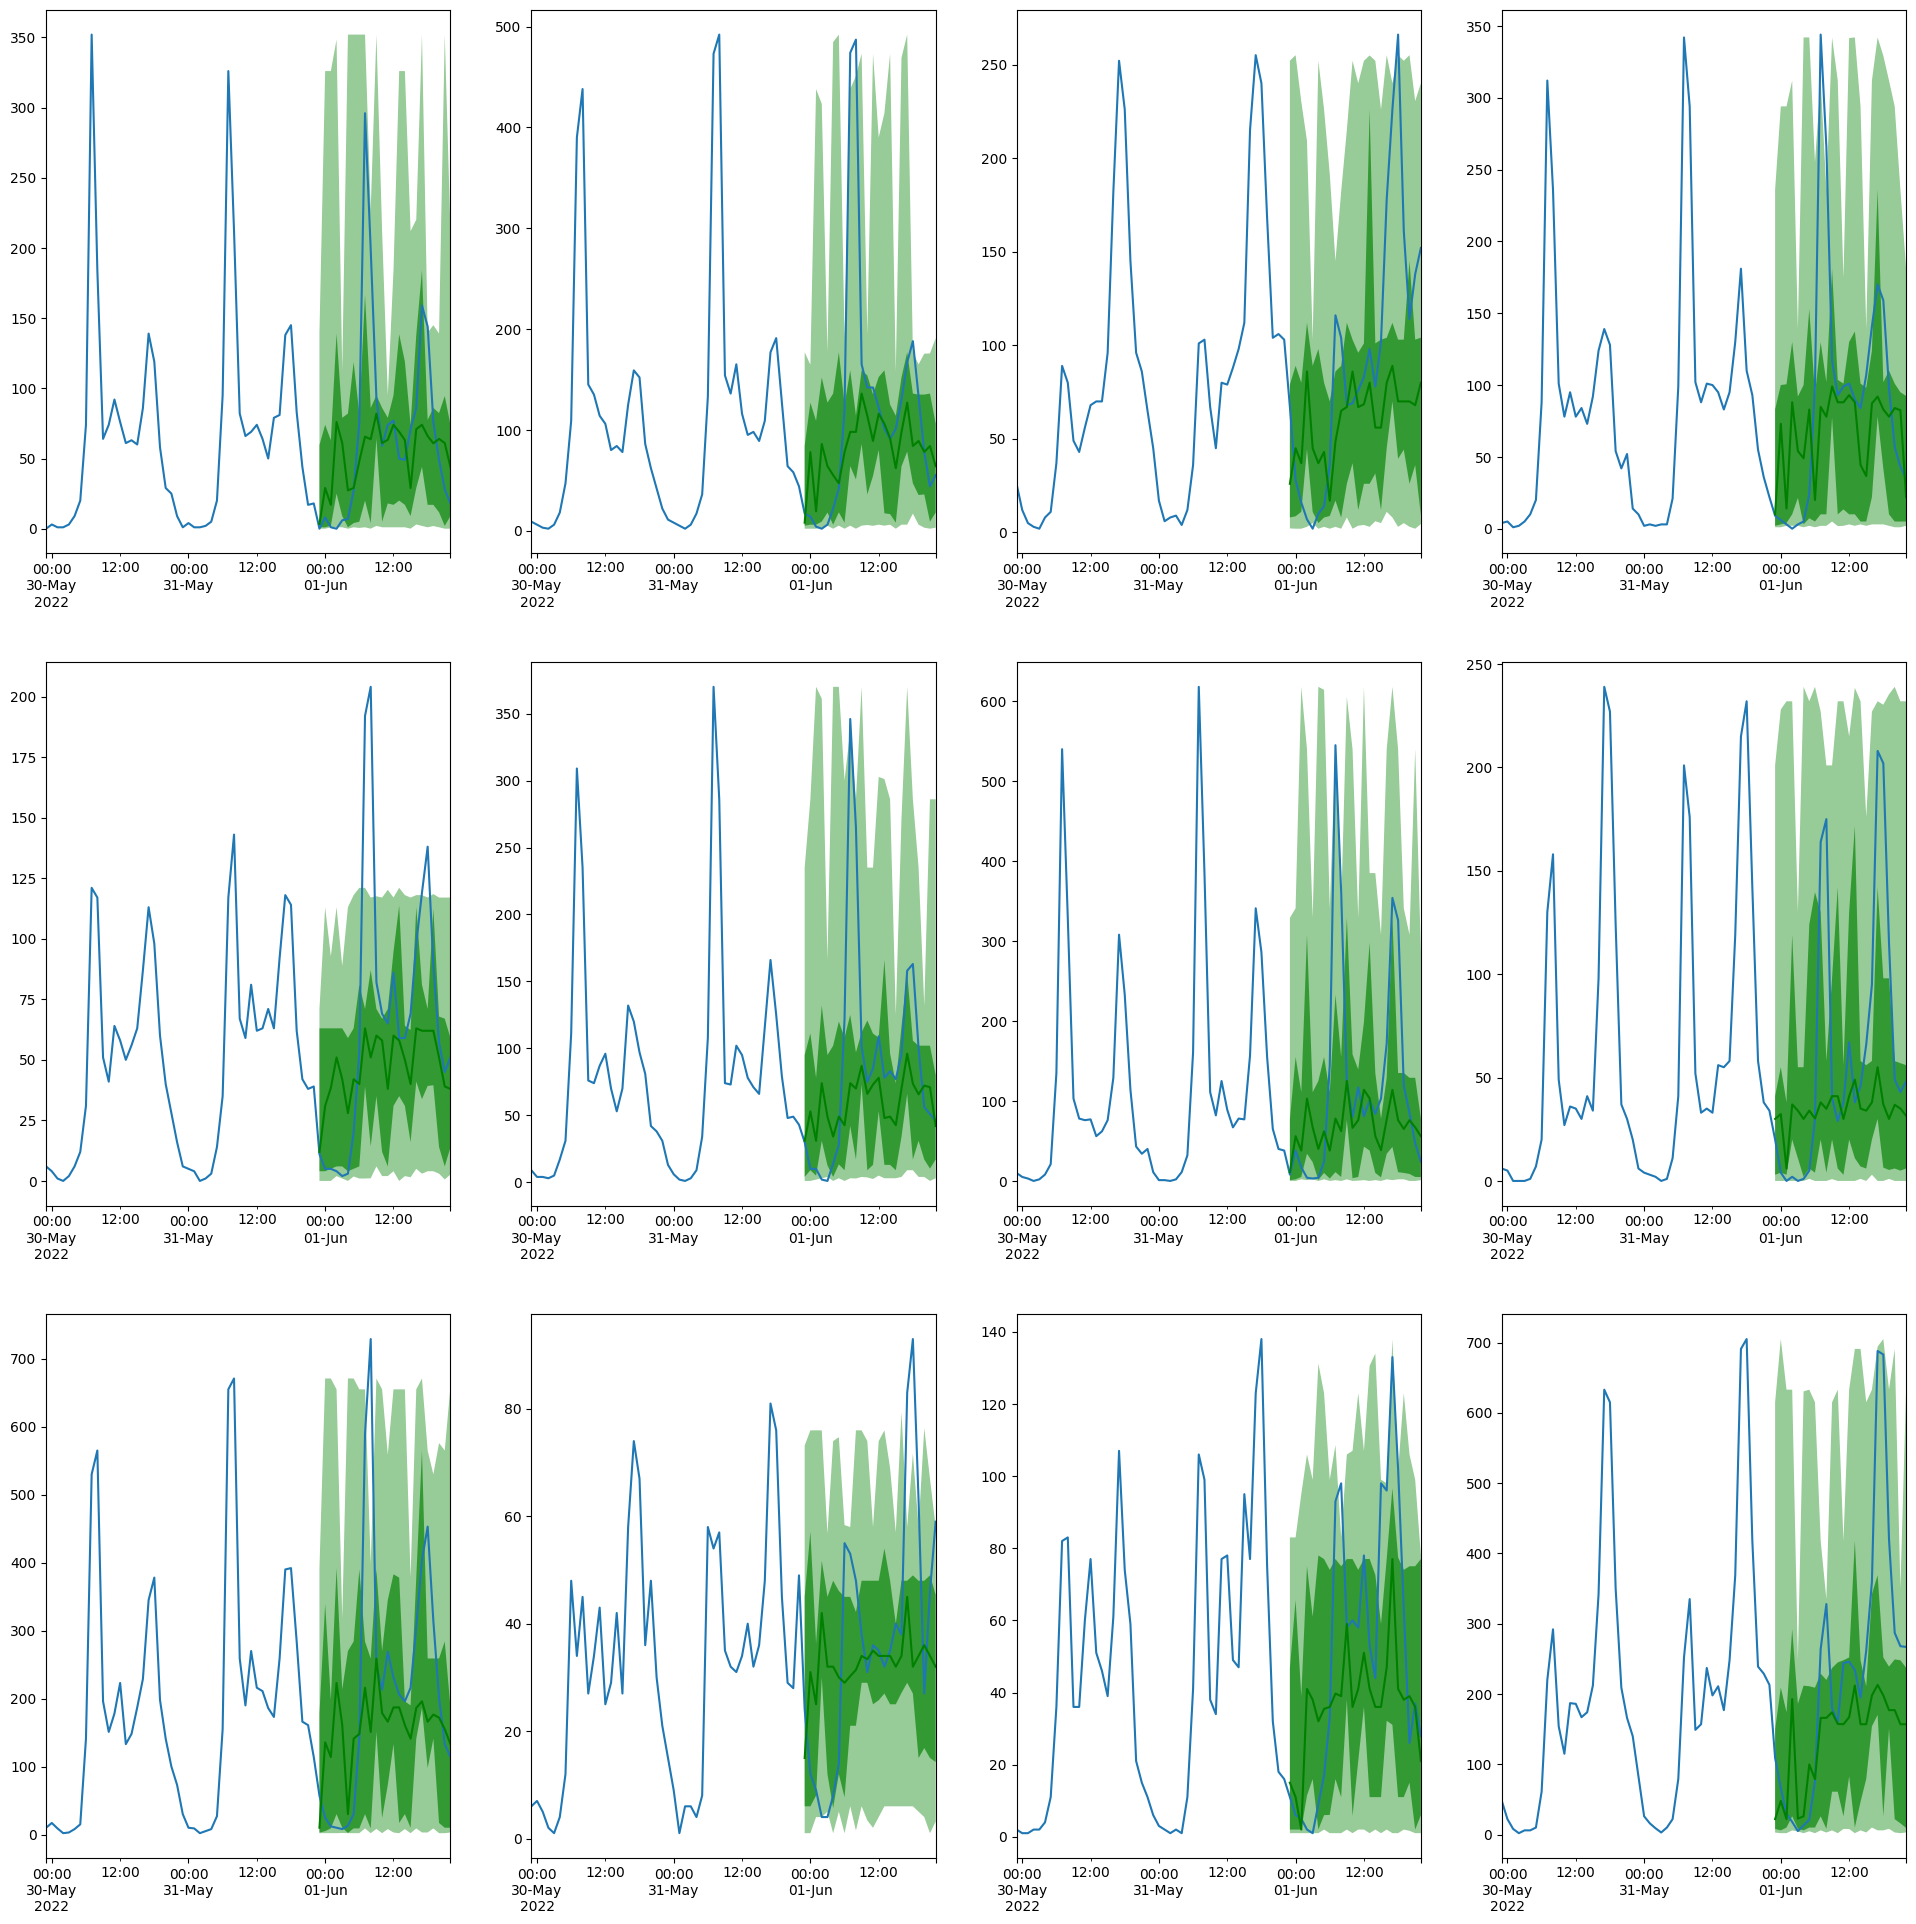

In [ ]:
plot(targets[-1], forecasts[-1], prediction_length = prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None)


Les prédictions faites ne sont pas satisfaisantes ici, pour deux raisons :
* Les profils médians prédits ne suivent pas les profils journaliers de traffic observés, notamment les pics.
* Les enveloppes de prédiction sont trop grandes ! Il ne nous est pas utile d'avoir ce type d'information.

Nous allons tester le 3ème modèle, basé sur des processus gaussiens, pour constater si nous obtenons de meilleurs résultats.

# Entraînement d'un modèle de prédiction GP-Copula

Nous allons passer à un dernier modèle : le *GP-Copula*. Ici encore,vous allez construire l'estimateur. Voici quelques indications :
* Il s'agit d'un modèle GP : utilisez la classe *GPVAREstimator* (documentation : https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.model.gpvar.html).
* Vous devez préciser un nombre de séries à échantilloner dans chaque itération d'entraînement, prenez 5. 
* Précisez la transformation des données souhaitée, la même que pour le modèle Vec-lstm-lowrank-copula.
* Utilisez une distribution de sortie adaptée. Ici nous souhaitons un processus gaussien avec matrice de faible rang en sortie. Cherchez la distribution adaptée dans la documentation : https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.distribution.html. Choisissez un rang pour la matrice de covariance (une valeur petite, 5 par défaut, que vous devez là aussi préciser dans les arguments de la classe *GPVAREstimator*).
* Enfin nous conserverons les mêmes valeurs d'hyperparamètres que dans les deux modèle précédents pour le réseau de neurone (lags, dropout, etc.). Nous gardons 10 epochs.

In [ ]:
#Création d'un estimateur pour un modèle GP-copula
estimator = GPVAREstimator(
            target_dim=target_dim,
            dropout_rate=0.01,
            prediction_length=prediction_length,
            cell_type="lstm",
            lags_seq = [1, 2, 12, 24],
            scaling=False,
            rank = 5,
            target_dim_sample = 5,
            freq=freq,
            use_marginal_transformation=True,
            distr_output=LowrankGPOutput(rank = 5, dim = target_dim),
            trainer=Trainer(
         epochs=10,
         learning_rate=1e-3,
         num_batches_per_epoch=10),
        )

#Entrainement sur la base d'apprentissage avec l'estimateur crée
predictor = estimator.train(train_ds)


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/gluonts/transform/convert.py:556: RuntimeWarning: divide by zero encountered in true_divide
  x_diff == 0.0, np.zeros_like(x_diff), y_diff / x_diff
/usr/local/lib/python3.9/dist-packages/gluonts/transform/convert.py:556: RuntimeWarning: divide by zero encountered in true_divide
  x_diff == 0.0, np.zeros_like(x_diff), y_diff / x_diff
100%|██████████| 10/10 [00:12<00:00,  1.22s/it, epoch=10/10, avg_epoch_loss=-2.63]


Une fois votre modèle construit et entraîné, vous allez pouvoir lancer des prédictions sur la base de test.

In [ ]:
#Prédictions sur fenêtres glissantes
forecast_it, ts_it = make_evaluation_predictions(
                test_ds, predictor=predictor, num_samples=30
            )

forecasts = list(forecast_it)
targets = list(ts_it)

# Evaluation
agg_metric, item_metrics = evaluator(
                    targets, forecasts, num_series=len(test_ds)
                )

print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("MSE: {}".format(agg_metric['MSE']))

/usr/local/lib/python3.9/dist-packages/gluonts/transform/convert.py:809: RuntimeWarning: divide by zero encountered in true_divide
  (
/usr/local/lib/python3.9/dist-packages/gluonts/transform/convert.py:809: RuntimeWarning: invalid value encountered in true_divide
  (
Running evaluation: 7it [00:00, 107.76it/s]
Running evaluation: 7it [00:00, 96.76it/s]
Running evaluation: 7it [00:00, 112.52it/s]
Running evaluation: 7it [00:00, 118.39it/s]
Running evaluation: 7it [00:00, 109.43it/s]
Running evaluation: 7it [00:00, 111.99it/s]
Running evaluation: 7it [00:00, 107.92it/s]
Running evaluation: 7it [00:00, 104.07it/s]
Running evaluation: 7it [00:00, 93.54it/s]
Running evaluation: 7it [00:00, 117.66it/s]
Running evaluation: 7it [00:00, 118.19it/s]
Running evaluation: 7it [00:00, 113.61it/s]
Running evaluation: 7it [00:00, 88.87it/s]
Running evaluation: 7it [00:00, 113.46it/s]
Running evaluation: 7it [00:00, 119.02it/s]
Running evaluation: 7it [00:00, 104.84it/s]
Running evaluation: 7it [00:00

CRPS: 0.45422801992311623
MSE: 1194.5533117467346


Constatez vous une amélioration sur les métriques de test CRPS et MSE ? A votre avis pourquoi ? 

Visualisons quelques unes des prédictions faites avec ce nouveau modèle. 

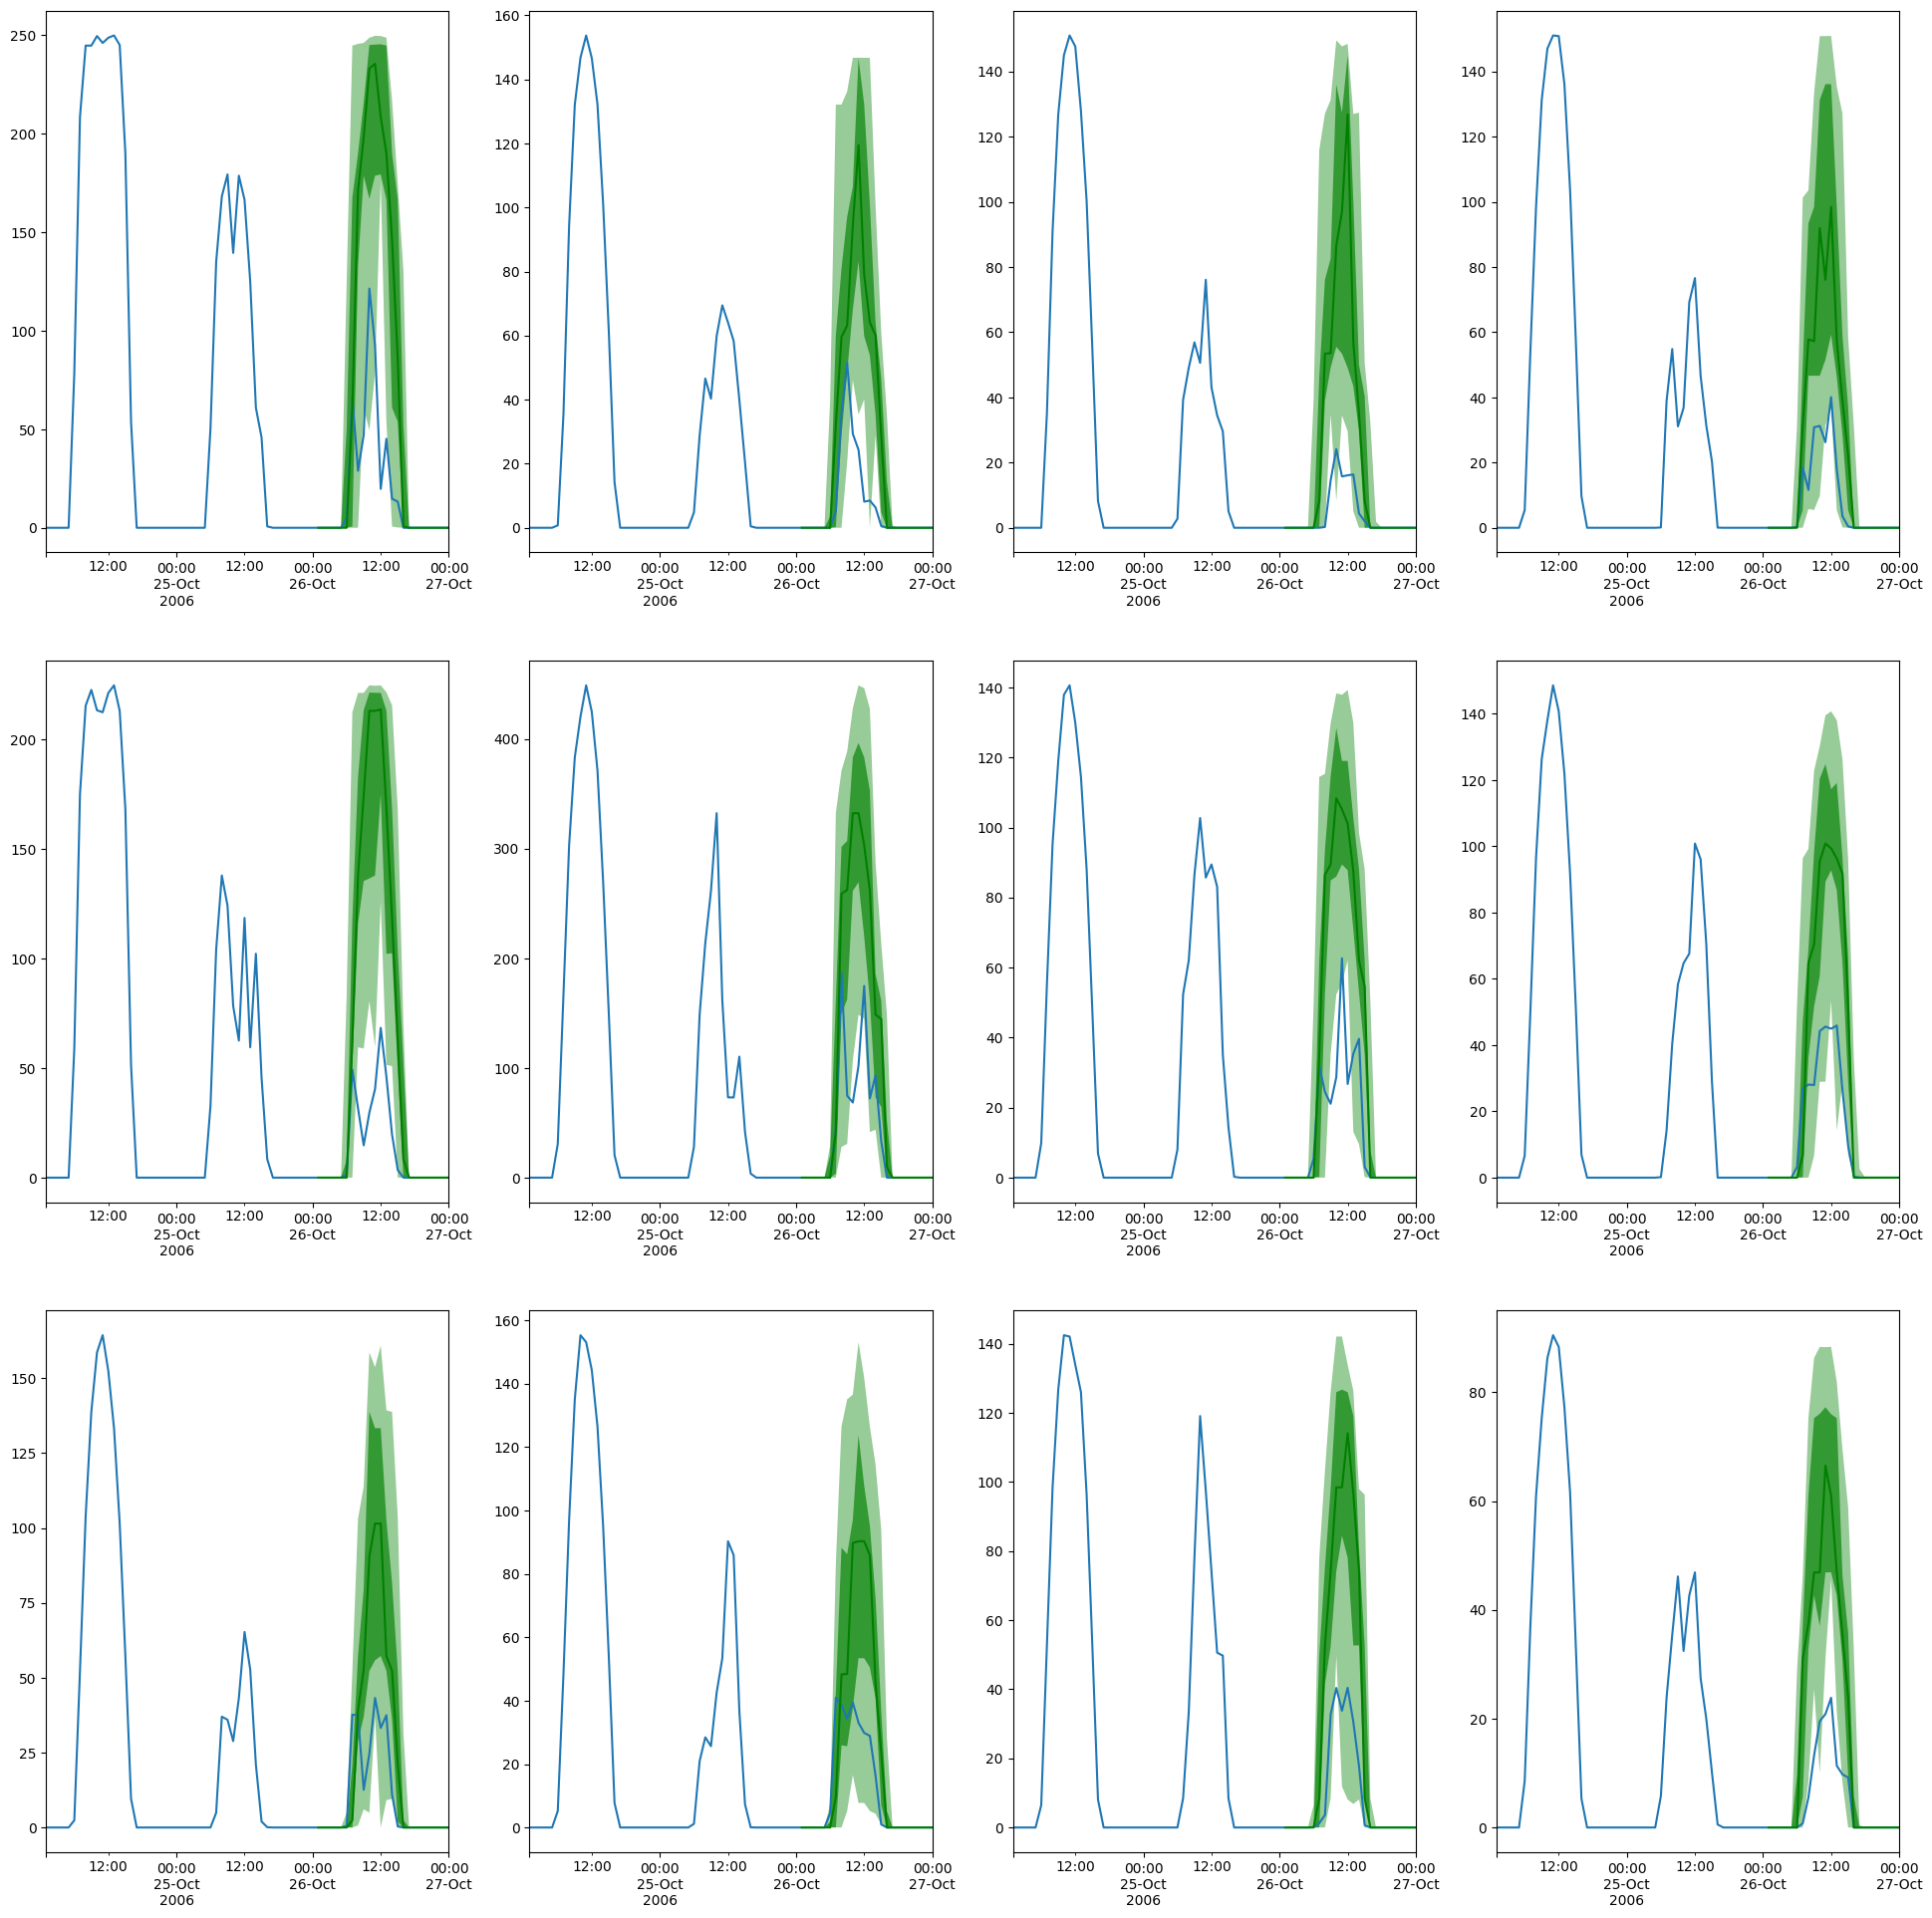

In [ ]:
plot(targets[-1], forecasts[-1], prediction_length = prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None)


Les prédictions sont nettement plus proches de la réalité avec ce modèle.

En pratique la recherche d'un bon modèle de prédiction n'est pas très différente de ce que nous avons vu dans cet atelier. Il s'agit d'alterner entre des phases d'entraînement et d'évaluation qui permettent de sélectionner :
* Une bonne architecture pour le modèle de prédiction. Ici nous voyons un avantage du modèle GP sur les autres mais cela peut être différent selon les données que l'on étudie.
* Un bon jeu d'hyperparamètres, à travers une grille de recherche. 



#Pour terminer

Si vous avez terminé l'atelier à ce stade, je vous propose de tester un autre jeu de données, disponible avec la librairie GluonTS. *Solar* contient la production de 137 panneaux photovoltaïques dans l'état de l'Alabama. Ci-dessous, voici les codes nécessaires à l'importation des données depuis GluonTS et la création des objets itérables pour l'entraînement et l'évaluation. 

Utilisez ces données pour entraîner un modèle (GP-copula, Vec-lstm,...), l'évaluer et visualiser les prédictions. Vous pouvez modifier les hyperparamètres pour constater leur impact sur vos prédictions. Attention, des valeurs importantes de certains hyperparamètres peuvent entraîner des temps de calcul trop longs.

In [ ]:
#Fonctions nécessaires à l'importation de données accessibles avec GluonTS
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

#Sélection du dataset
dataset = get_dataset("solar-energy")
target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
freq=dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length
  

#Créations des bases d'entraînement et de test
train_grouper = MultivariateGrouper(max_target_dim=target_dim)

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=target_dim)

train_ds = train_grouper(dataset.train)
test_ds = test_grouper(dataset.test)

Les bases d'entraînement et de test sont créees. Vous pouvez faire apprendre ces données à un nouveau modèle.

In [ ]:
#Estimation et prédictions pour le modèle ... appliqué aux données Solar

estimator = ...
predictor = ...

Merci d'avoir suivi cet atelier ! 